##### Version 0.5 -- April 2015

# Vortex-source panel method

In [Lesson 9](http://nbviewer.ipython.org/urls/github.com/barbagroup/AeroPython/blob/master/lessons/09_Lesson09_flowOverCylinder.ipynb) of _AeroPython_, you learned to use a _source panel method_ to represent a circular cylinder, and in [Lesson 10](http://nbviewer.ipython.org/urls/github.com/barbagroup/AeroPython/blob/master/lessons/10_Lesson10_sourcePanelMethod.ipynb) we used it for a symmetric airfoil at zero angle of attack. But what if we want the airfoil to generate some lift? If we place the airfoil at a non-zero angle of attack, we _should_ get lift, but will a source-panel representation be able to give you lift? Remember the [_Kutta-Joukowski theorem_](http://en.wikipedia.org/wiki/Kutta%E2%80%93Joukowski_theorem)?


Historically, the first panel method ever developed was a source-sheet method. At the time, Douglas Aircraft Company was concerned with calculating the flow around bodies of revolution, and it was only later that the method was extended to lifting surfaces. (See the reference below for a nice historical account.)

A *source-panel method* leads to a solution with no circulation, therefore no lift. The objective of this lesson is to start with the source panel method we implemented in the previous lesson and add some *circulation* so that we may have a lift force. We introduce an important concept: the **Kutta-condition** that allows us to determine what the right amount of circulation should be.

##### Reference

* Smith, A.M.O., The Panel Method: Its Original Development. In _Applied Computational Aerodynamics_, Vol. 125, edited by P.A. Henne, published by AIAA (1990). [Read it on Google Books.](http://books.google.com/books?id=5Ov2tHj0wxoC&lpg=PA3&ots=SnUiqcdEnb&dq=The%20Panel%20Method%3A%20Its%20Original%20Development&pg=PA3#v=onepage&q&f=false)

## A lifting-body panel method

If we were to simply increase the angle of attack in the freestream and calculate the flow with a source sheet only, the rear stagnation point will not be located at the trailing edge. Instead, the flow will bend around the trailing edge and the stagnation point will be somewhere on the top surface of the airfoil. This is not a physically possible solution.

For example, using the source-sheet panel method of [Lesson 10](http://nbviewer.ipython.org/github/barbagroup/AeroPython/blob/master/lessons/10_Lesson10_sourcePanelMethod.ipynb) with an angle of attack $\alpha=4^\circ$ (using 40 panels), and plotting the streamlines in an area close to the trailing edge, we get the following plot:

<center><img src="./resources/StreamlinesTrailingEdge.png" width="600"></center>

As you can see, the streamlines behave strangely at the trailing edge. We know experimentally that the flow leaves the trailing edge of an airfoil smoothly, so this must be wrong. Well, it's just that we can't use purely sources to calculate potential flow of an airfoil at non-zero angle of attack—we need circulation. But how do we obtain circulation?

### The Kutta condition

The *Kutta-condition* states that the pressure below and above the airfoil trailing edge must be equal so that the flow does not bend around it, but leaves tangentially. The rear stagnation point must be exactly at the trailing edge.

It's natural to be a little perplexed by this. How can we justify this seemingly arbitrary condition? Remember that potential-flow theory completely ignores fluid viscosity, so if we are leaving out this physical effect, we shouldn't be surprised that the theory needs some adjustment for those situations when viscosity does play a role. A real viscous fluid is not able to turn around a sharp corner like an airfoil trailing edge without separating there. The Kutta condition allows us to correct potential-flow theory so that it gives a solution closer to reality.

Remember [Lesson 6](http://nbviewer.ipython.org/github/barbagroup/AeroPython/blob/master/lessons/06_Lesson06_vortexLift.ipynb), where we studied lift on a cylinder by combining a doublet and a freestream, plus a vortex. That's when we learned that **lift always requires circulation**. If you experimented with the circulation of the point vortex (which you *did*, right?), you found that the stagnation points moved along the cylinder.

Like for the circular cylinder, the amount of circulation we add to an airfoil will move the stagnation points along the surface. And if we add just the right amount, the rear stagnation point can be made to coincide with the trailing edge. This amount of circulation makes the flow a physically relevant solution. And this amount gives the correct lift!

To implement the Kutta-condition in our panel method we need to add one more equation to the system, giving the circulation that moves the stagnation point to the trailing edge. By placing a vortex-sheet with the same constant strength at every panel, we can add the circulation to the flow with just one more unknown.

How do we enforce this in our code? We can re-use most of the code from Lesson 10, and enforce the Kutta-condition while adding circulation to the flow. Previously, we discretized the geometry into `N` panels, with a constant source strength on each one (varying from panel to panel), and applied a Neumann boundary condition of flow tangency at the `N` panel centers. This led to a linear system of `N` equations and `N` unknowns that we solved with the NumPy function `linalg.solve()`. In the lifting-body case, we will instead have `N+1` equations and `N+1` unknowns. Read on to find out how!


### Discretization into panels

Let's get the preliminaries out of the way. We need to import our favorite libraries, and the function `integrate` from SciPy, as in Lesson 10.

In [1]:
import math
import numpy
from scipy import integrate
from matplotlib import pyplot

We start by importing the NACA0012 geometry from a data file, and we plot the airfoil:

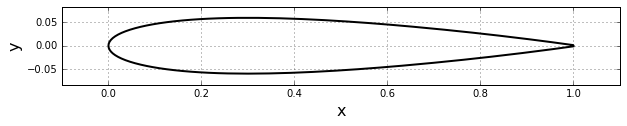

In [2]:
# reads of the geometry from a data file
with open ('./resources/naca0012.dat') as file_name:
    x, y = numpy.loadtxt(file_name, dtype=float, delimiter='\t', unpack=True)

# plots the geometry
%matplotlib inline

val_x, val_y = 0.1, 0.2
x_min, x_max = x.min(), x.max()
y_min, y_max = y.min(), y.max()
x_start, x_end = x_min-val_x*(x_max-x_min), x_max+val_x*(x_max-x_min)
y_start, y_end = y_min-val_y*(y_max-y_min), y_max+val_y*(y_max-y_min)

size = 10
pyplot.figure(figsize=(size, (y_end-y_start)/(x_end-x_start)*size))
pyplot.grid(True)
pyplot.xlabel('x', fontsize=16)
pyplot.ylabel('y', fontsize=16)
pyplot.xlim(x_start, x_end)
pyplot.ylim(y_start, y_end)
pyplot.plot(x, y, color='k', linestyle='-', linewidth=2);

The contour defining the airfoil will be partitioned into `N` panels, using the same method as in the [Lesson 10](http://nbviewer.ipython.org/github/barbagroup/AeroPython/blob/master/lessons/10_Lesson10_sourcePanelMethod.ipynb).

We define a class `Panel`  that will store all information about one panel: start and end points, center point, length, orientation, source strength, tangential velocity and pressure coefficient. We don't save the vortex-sheet strength because all panels will have the same value.

In [3]:
class Panel:
    """Contains information related to one panel."""
    def __init__(self, xa, ya, xb, yb):
        """Creates a panel.
        
        Arguments
        ---------
        xa, ya -- Cartesian coordinates of the first end-point.
        xb, yb -- Cartesian coordinates of the second end-point.
        """
        self.xa, self.ya = xa, ya
        self.xb, self.yb = xb, yb
        
        self.xc, self.yc = (xa+xb)/2, (ya+yb)/2       # control-point (center-point)
        self.length = math.sqrt((xb-xa)**2+(yb-ya)**2)     # length of the panel
        
        # orientation of the panel (angle between x-axis and panel's normal)
        if xb-xa <= 0.:
            self.beta = math.acos((yb-ya)/self.length)
        elif xb-xa > 0.:
            self.beta = math.pi + math.acos(-(yb-ya)/self.length)
        
        # location of the panel
        if self.beta <= math.pi:
            self.loc = 'extrados'
        else:
            self.loc = 'intrados'
        
        self.sigma = 0.                             # source strength
        self.vt = 0.                                # tangential velocity
        self.cp = 0.                                # pressure coefficient

Like before, we call the function `define_panels()` to discretize the airfoil geometry in `N` panels. The function will return a NumPy array of `N` objects of the type `Panel`.

In [4]:
def define_panels(x, y, N=40):
    """Discretizes the geometry into panels using 'cosine' method.
    
    Arguments
    ---------
    x, y -- Cartesian coordinates of the geometry (1D arrays).
    N - number of panels (default 40).
    
    Returns
    -------
    panels -- Numpy array of panels.
    """
    R = (x.max()-x.min())/2                                    # radius of the circle
    x_center = (x.max()+x.min())/2                             # x-coord of the center
    x_circle = x_center + R*numpy.cos(numpy.linspace(0, 2*math.pi, N+1))  # x-coord of the circle points
    
    x_ends = numpy.copy(x_circle)      # projection of the x-coord on the surface
    y_ends = numpy.empty_like(x_ends)  # initialization of the y-coord Numpy array

    x, y = numpy.append(x, x[0]), numpy.append(y, y[0])    # extend arrays using numpy.append
    
    # computes the y-coordinate of end-points
    I = 0
    for i in range(N):
        while I < len(x)-1:
            if (x[I] <= x_ends[i] <= x[I+1]) or (x[I+1] <= x_ends[i] <= x[I]):
                break
            else:
                I += 1
        a = (y[I+1]-y[I])/(x[I+1]-x[I])
        b = y[I+1] - a*x[I+1]
        y_ends[i] = a*x_ends[i] + b
    y_ends[N] = y_ends[0]
    
    panels = numpy.empty(N, dtype=object)
    for i in range(N):
        panels[i] = Panel(x_ends[i], y_ends[i], x_ends[i+1], y_ends[i+1])
    
    return panels

Now we can use our new function to define the geometry for the airfoil panels, and then plot the panel nodes on the geometry.

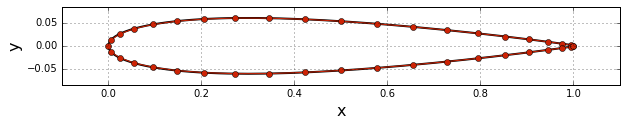

In [5]:
N = 40                            # number of panels
panels = define_panels(x, y, N)  # discretizes of the geometry into panels

# plots the geometry and the panels
val_x, val_y = 0.1, 0.2
x_min, x_max = min( panel.xa for panel in panels ), max( panel.xa for panel in panels )
y_min, y_max = min( panel.ya for panel in panels ), max( panel.ya for panel in panels )
x_start, x_end = x_min-val_x*(x_max-x_min), x_max+val_x*(x_max-x_min)
y_start, y_end = y_min-val_y*(y_max-y_min), y_max+val_y*(y_max-y_min)

size = 10
pyplot.figure(figsize=(size, (y_end-y_start)/(x_end-x_start)*size))
pyplot.grid(True)
pyplot.xlabel('x', fontsize=16)
pyplot.ylabel('y', fontsize=16)
pyplot.xlim(x_start, x_end)
pyplot.ylim(y_start, y_end)
pyplot.plot(x, y, color='k', linestyle='-', linewidth=2)
pyplot.plot(numpy.append([panel.xa for panel in panels], panels[0].xa), 
         numpy.append([panel.ya for panel in panels], panels[0].ya), 
         linestyle='-', linewidth=1, marker='o', markersize=6, color='#CD2305');

### Free-stream conditions

The airfoil is immersed in a free-stream ($U_\infty$,$\alpha$) where $U_\infty$ and $\alpha$ are the velocity magnitude and angle of attack, respectively. Like before, we create a class for the free stream, even though we will only have one object that uses this class. It makes it easier to pass the free stream to other functions later on.

In [6]:
class Freestream:
    """Freestream conditions."""
    def __init__(self, u_inf=1.0, alpha=0.0):
        """Sets the freestream conditions.
        
        Arguments
        ---------
        u_inf -- Farfield speed (default 1.0).
        alpha -- Angle of attack in degrees (default 0.0).
        """
        self.u_inf = u_inf
        self.alpha = alpha*math.pi/180          # degrees --> radians

In [7]:
# defines and creates the object freestream
u_inf = 1.0                                # freestream spee
alpha = 4.0                                # angle of attack (in degrees)
freestream = Freestream(u_inf, alpha)      # instantiation of the object freestream

### Flow tangency boundary condition

A constant vortex strength $\gamma$ will be added to each panel (all panels have the same, constant vortex-sheet strength). Thus, using the principle of superposition, the velocity potential becomes:

$$
\begin{align*}
\phi\left(x_{c_i},y_{c_i}\right) &= V_\infty x_{c_i} \cos \alpha + V_\infty y_{c_i} \sin \alpha \\
&+ \sum_{j=1}^N \frac{\sigma_j}{2\pi} \int_j \ln \left(\sqrt{(x_{c_i}-x_j(s_j))^2+(y_{c_i}-y_j(s_j))^2} \right) {\rm d}s_j \\
&- \sum_{j=1}^N \frac{\gamma}{2\pi} \int_j \tan^{-1} \left(\frac{y_{c_i}-y_j(s_j)}{x_{c_i}-x_j(s_j)}\right) {\rm d}s_j
\end{align*}
$$

The flow tangency boundary condition is applied at every panel center:

$$0 = \underline{V}\cdot\underline{n}_i = \frac{\partial}{\partial n_i} \left\{ \phi\left(x_{c_i},y_{c_i}\right) \right\}$$

i.e.

$$
\begin{align*}
0 &= V_\infty \cos \left(\alpha-\beta_i\right) + \frac{\sigma_i}{2} \\
&+ \sum_{j=1,j\neq i}^N \frac{\sigma_j}{2\pi} \int_j \frac{\partial}{\partial n_i} \ln \left(\sqrt{(x_{c_i}-x_j(s_j))^2+(y_{c_i}-y_j(s_j))^2} \right) {\rm d}s_j \\
&- \sum_{j=1,j\neq i}^N \frac{\gamma}{2\pi} \int_j \frac{\partial}{\partial n_i} \tan^{-1} \left(\frac{y_{c_i}-y_j(s_j)}{x_{c_i}-x_j(s_j)}\right) {\rm d}s_j
\end{align*}
$$

We already worked the first integral in the previous lesson:

$$\frac{\partial}{\partial n_i} \ln \left(\sqrt{(x_{c_i}-x_j(s_j))^2+(y_{c_i}-y_j(s_j))^2} \right) = \frac{\left(x_{c_i}-x_j\right)\frac{\partial x_{c_i}}{\partial n_i} + \left(y_{c_i}-y_j\right)\frac{\partial y_{c_i}}{\partial n_i}}{\left(x_{c_i}-x_j\right)^2 + \left(x_{c_i}-x_j\right)^2}$$

where $\frac{\partial x_{c_i}}{\partial n_i} = \cos \beta_i$ and $\frac{\partial y_{c_i}}{\partial n_i} = \sin \beta_i$, and:

$$x_j(s_j) = x_{b_j} - s_j \sin \beta_j$$

$$y_j(s_j) = y_{b_j} + s_j \cos \beta_j$$

We now need to derive the last integral of the boundary equation:

$$\frac{\partial}{\partial n_i} \tan^{-1} \left(\frac{y_{c_i}-y_j(s_j)}{x_{c_i}-x_j(s_j)}\right)= \frac{\left(x_{c_i}-x_j\right)\frac{\partial y_{c_i}}{\partial n_i} - \left(y_{c_i}-y_j\right)\frac{\partial x_{c_i}}{\partial n_i}}{\left(x_{c_i}-x_j\right)^2 + \left(y_{c_i}-y_j\right)^2}$$

where $\frac{\partial x_{c_i}}{\partial n_i} = \cos \beta_i$ and $\frac{\partial y_{c_i}}{\partial n_i} = \sin \beta_i$.

### Enforcing the Kutta-condition

To enforce the *Kutta-condition*, we state that the pressure coefficient on the first panel must be equal to that on the last panel:

$$C_{p_1} = C_{p_{N}}$$

Using the definition of the pressure coefficient $C_p = 1-\left(\frac{V}{U_\infty}\right)^2$, the Kutta-condition implies that the magnitude of the velocity at the first panel center must equal the magnitude of the last panel center:

$$V_1^2 = V_N^2$$

Since the flow tangency condition requires that $V_{n_1} = V_{n_N} = 0$, we end up with the following *Kutta-condition*:

$$V_{t_1} = - V_{t_N}$$

(the minus sign comes from the reference axis we chose for the normal and tangential vectors).


Therefore, we need to evaluate the tangential velocity at the first and last panels. 

In [Lesson 8](http://nbviewer.ipython.org/github/barbagroup/AeroPython/blob/master/lessons/08_Lesson08_sourceSheet.ipynb), we saw that the normal velocity induced by a source sheet panel on itself is $\frac{\sigma}{2}$. In a similar fashion, we can show that the tangential velocity induced by a vortex sheet panel on itself is $-\frac{\gamma}{2}$.

Let's derive the tangential velocity for every panel, since it will be useful to compute the pressure coefficient.

$$V_{t_i} = \frac{\partial}{\partial t_i} \left(\phi\left(x_{c_i},y_{c_i}\right)\right)$$

i.e.,

$$
\begin{align*}
V_{t_i} &= V_\infty \sin \left(\alpha-\beta_i\right) \\
&+ \sum_{j=1,j\neq i}^N \frac{\sigma_j}{2\pi} \int_j \frac{\partial}{\partial t_i} \ln \left(\sqrt{(x_{c_i}-x_j(s_j))^2+(y_{c_i}-y_j(s_j))^2} \right) {\rm d}s_j \\
&- \sum_{j=1,j\neq i}^N \frac{\gamma}{2\pi} \int_j \frac{\partial}{\partial t_i} \tan^{-1} \left(\frac{y_{c_i}-y_j(s_j)}{x_{c_i}-x_j(s_j)}\right) {\rm d}s_j \\
&-\frac{\gamma}{2}
\end{align*}
$$


which gives

$$
\begin{align*}
V_{t_i} &= V_\infty \sin \left(\alpha-\beta_i\right) \\
&+ \sum_{j=1,j\neq i}^N \frac{\sigma_j}{2\pi} \int_j \frac{\left(x_{c_i}-x_j\right)\frac{\partial x_{c_i}}{\partial t_i} + \left(y_{c_i}-y_j\right)\frac{\partial y_{c_i}}{\partial t_i}}{\left(x_{c_i}-x_j\right)^2 + \left(x_{c_i}-x_j\right)^2} {\rm d}s_j \\
&- \sum_{j=1,j\neq i}^N \frac{\gamma}{2\pi} \int_j \frac{\left(x_{c_i}-x_j\right)\frac{\partial y_{c_i}}{\partial t_i} - \left(y_{c_i}-y_j\right)\frac{\partial x_{c_i}}{\partial t_i}}{\left(x_{c_i}-x_j\right)^2 + \left(x_{c_i}-x_j\right)^2} {\rm d}s_j \\
&-\frac{\gamma}{2}
\end{align*}
$$

where $\frac{\partial x_{c_i}}{\partial t_i} = -\sin \beta_i$ and $\frac{\partial y_{c_i}}{\partial t_i} = \cos \beta_i$.

### Building the linear system

Here, we build and solve the linear system of equations of the form

$$[A][\sigma,\gamma] = [b]$$

where the $N+1 \times N+1$ matrix $[A]$ contains three blocks: an $N \times N$ source matrix (the same one of Lesson 10), an $N \times 1$ vortex array to store the weight of the variable $\gamma$ at each panel, and a $1 \times N+1$ Kutta array that repesents our Kutta-condition.

We are going to re-use the function `integral()` from Lesson 10 to compute the different integrals with the NumPy function `integrate.quad()`:

In [8]:
def integral(x, y, panel, dxdz, dydz):
    """Evaluates the contribution of a panel at one point.
    
    Arguments
    ---------
    x, y -- Cartesian coordinates of the point.
    panel -- panel which contribution is evaluated.
    dxdz -- derivative of x in the z-direction.
    dydz -- derivative of y in the z-direction.
    
    Returns
    -------
    Integral over the panel of the influence at one point.
    """
    def func(s):
        return ( ((x - (panel.xa - math.sin(panel.beta)*s))*dxdz 
                  + (y - (panel.ya + math.cos(panel.beta)*s))*dydz)
                / ((x - (panel.xa - math.sin(panel.beta)*s))**2 
                   + (y - (panel.ya + math.cos(panel.beta)*s))**2) )
    return integrate.quad(lambda s:func(s), 0., panel.length)[0]

We first build the source matrix:

In [9]:
def source_matrix(panels):
    """Builds the source matrix.
    
    Arguments
    ---------
    panels -- array of panels.
    
    Returns
    -------
    A -- NxN matrix (N is the number of panels).
    """
    A = numpy.empty((panels.size, panels.size), dtype=float)
    numpy.fill_diagonal(A, 0.5)
    
    for i, p_i in enumerate(panels):
        for j, p_j in enumerate(panels):
            if i != j:
                A[i,j] = 0.5/math.pi*integral(p_i.xc, p_i.yc, 
                                              p_j, 
                                              math.cos(p_i.beta), math.sin(p_i.beta))
    
    return A

then the vortex array:

In [10]:
def vortex_array(panels):
    """Builds the vortex array.
    
    Arguments
    ---------
    panels - array of panels.
    
    Returns
    -------
    a -- 1D array (Nx1, N is the number of panels).
    """
    a = numpy.zeros(panels.size, dtype=float)
    
    for i, p_i in enumerate(panels):
        for j, p_j in enumerate(panels):
            if i != j:
                a[i] -= 0.5/math.pi*integral(p_i.xc, p_i.yc, 
                                             p_j, 
                                             math.sin(p_i.beta), -math.cos(p_i.beta))
    return a

and finally the Kutta array:

In [11]:
def kutta_array(panels):
    """Builds the Kutta-condition array.
    
    Arguments
    ---------
    panels -- array of panels.
    
    Returns
    -------
    a -- 1D array (Nx1, N is the number of panels).
    """
    N = panels.size
    a = numpy.zeros(N+1, dtype=float)
    # contribution from the source sheet of the first panel on the last one
    a[0] = 0.5/math.pi*integral(panels[N-1].xc, panels[N-1].yc, panels[0], 
                           -math.sin(panels[N-1].beta), +math.cos(panels[N-1].beta))
    # contribution from the source sheet of the last panel on the first one
    a[N-1] = 0.5/math.pi*integral(panels[0].xc, panels[0].yc, panels[N-1], 
                             -math.sin(panels[0].beta), +math.cos(panels[0].beta))
    # contribution from the vortex sheet of the first panel on the last one
    a[N] -= 0.5/math.pi*integral(panels[-1].xc, panels[-1].yc, panels[0], 
                               +math.cos(panels[-1].beta), math.sin(panels[-1].beta))
    # contribution from the vortex sheet of the last panel on the first one
    a[N] -= 0.5/math.pi*integral(panels[0].xc, panels[0].yc, panels[-1], 
                               +math.cos(panels[0].beta), math.sin(panels[0].beta))
    # contribution from the vortex sheet of the first panel on itself
    a[N] -= 0.5
    # contribution from the vortex sheet of the last panel on itself
    a[N] -= 0.5
 
    # contribution from the other panels on the first and last ones
    for i, panel in enumerate(panels[1:-1]):
        # contribution from the source sheet
        a[i+1] = 0.5/math.pi*(integral(panels[0].xc, panels[0].yc, panel, 
                               -math.sin(panels[0].beta), +math.cos(panels[0].beta))
                     + integral(panels[N-1].xc, panels[N-1].yc, panel, 
                               -math.sin(panels[N-1].beta), +math.cos(panels[N-1].beta)) )

        # contribution from the vortex sheet
        a[N] -= 0.5/math.pi*(integral(panels[0].xc, panels[0].yc, panel, 
                               +math.cos(panels[0].beta), math.sin(panels[0].beta))
                             + integral(panels[-1].xc, panels[-1].yc, panel, 
                               +math.cos(panels[-1].beta), math.sin(panels[-1].beta)) )
        
    return a

Now that the three blocks have be defined, we can assemble the matrix $[A]$:

In [12]:
def build_matrix(panels):
    """Builds the matrix of the linear system.
    
    Arguments
    ---------
    panels -- array of panels.
    
    Returns
    -------
    A -- (N+1)x(N+1) matrix (N is the number of panels).
    """
    N = len(panels)
    A = numpy.empty((N+1, N+1), dtype=float)
    
    AS = source_matrix(panels)
    av = vortex_array(panels)
    ak = kutta_array(panels)
    
    A[0:N,0:N], A[0:N,N], A[N,:] = AS[:,:], av[:], ak[:]
    
    return A

On the right hand-side, we store the free-stream conditions that do not depend on the unknowns strengths:

In [13]:
def build_rhs(panels, freestream):
    """Builds the RHS of the linear system.
    
    Arguments
    ---------
    panels -- array of panels.
    freestream -- farfield conditions.
    
    Returns
    -------
    b -- 1D array ((N+1)x1, N is the number of panels).
    """
    N = len(panels)
    b = numpy.empty(N+1,dtype=float)
    
    for i, panel in enumerate(panels):
        b[i] = - freestream.u_inf * math.cos(freestream.alpha - panel.beta)
    b[N] = -freestream.u_inf*( math.sin(freestream.alpha-panels[0].beta)
                              +math.sin(freestream.alpha-panels[N-1].beta) )
    
    return b

All in all, the system has been defined with the functions `source_matrix()`, `vortex_array()`, `kutta_array()` and `build_rhs()`, which we have to call to build the complete system:

In [14]:
A = build_matrix(panels)                  # calculates the singularity matrix
b = build_rhs(panels, freestream)         # calculates the freestream RHS

The linear system is then solved using the NumPy function `linalg.solve()`and we store the results in the attribute `sigma` of each object. We also create a variable `gamma` to store the value of the constant vortex strength. 

In [15]:
# solves the linear system
variables = numpy.linalg.solve(A, b)

for i, panel in enumerate(panels):
    panel.sigma = variables[i]
gamma = variables[-1]

### Surface pressure coefficient

The pressure coefficient at the $i$-th panel center is:

$$C_{p_i} = 1 - \left(\frac{V_{t_i}}{U_\infty}\right)^2$$

So, we have to compute the tangential velocity at each panel center using the function `get_tangential_velocity()`:

In [16]:
def get_tangential_velocity(panels, freestream, gamma):
    """Computes the tangential velocity on the surface.
    
    Arguments
    ---------
    panels -- array of panels.
    freestream -- farfield conditions.
    gamma -- circulation density.
    """
    N = len(panels)
    A = numpy.empty((N, N+1), dtype=float)
    numpy.fill_diagonal(A, 0.0)
    
    for i, p_i in enumerate(panels):
        # contribution from vortex on itself
        A[i, N] = -0.5
        for j, p_j in enumerate(panels):
            if i != j:
                # contribution from the sources
                A[i,j] = 0.5/math.pi*integral(p_i.xc, p_i.yc, 
                                              p_j, 
                                              -math.sin(p_i.beta), math.cos(p_i.beta))
                # contribution the vortices
                A[i,N] -= 0.5/math.pi*integral(p_i.xc, p_i.yc, 
                                               p_j, 
                                               math.cos(p_i.beta), math.sin(p_i.beta))

    b = freestream.u_inf * numpy.sin([freestream.alpha - panel.beta for panel in panels])
    
    var = numpy.append([panel.sigma for panel in panels], gamma)
    
    vt = numpy.dot(A, var) + b
    for i, panel in enumerate(panels):
        panel.vt = vt[i]

In [17]:
# computes the tangential velocity at each panel center.
get_tangential_velocity(panels, freestream, gamma)

And we define a function `get_pressure_coefficient()` to compute the surface pressure coefficient:

In [18]:
def get_pressure_coefficient(panels, freestream):
    """Computes the surface pressure coefficients.
    
    Arguments
    ---------
    panels -- array of panels.
    freestream -- farfield conditions.
    """
    for panel in panels:
        panel.cp = 1.0 - (panel.vt/freestream.u_inf)**2

In [19]:
# computes surface pressure coefficient
get_pressure_coefficient(panels, freestream)

Time to plot the result!

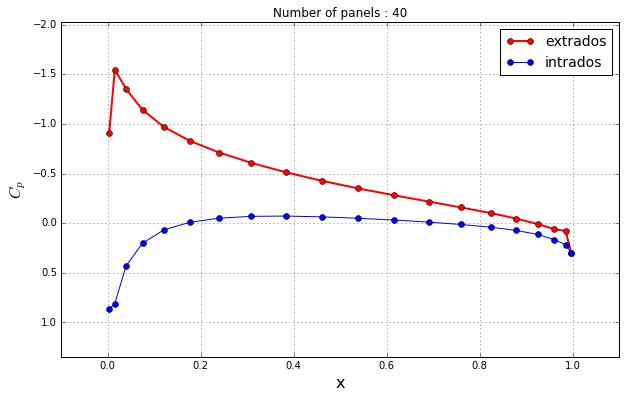

In [20]:
# plots the surface pressure coefficient
val_x, val_y = 0.1, 0.2
x_min, x_max = min( panel.xa for panel in panels ), max( panel.xa for panel in panels )
cp_min, cp_max = min( panel.cp for panel in panels ), max( panel.cp for panel in panels )
x_start, x_end = x_min-val_x*(x_max-x_min), x_max+val_x*(x_max-x_min)
y_start, y_end = cp_min-val_y*(cp_max-cp_min), cp_max+val_y*(cp_max-cp_min)

pyplot.figure(figsize=(10, 6))
pyplot.grid(True)
pyplot.xlabel('x', fontsize=16)
pyplot.ylabel('$C_p$', fontsize=16)
pyplot.plot([panel.xc for panel in panels if panel.loc == 'extrados'], 
         [panel.cp for panel in panels if panel.loc == 'extrados'], 
         color='r', linestyle='-', linewidth=2, marker='o', markersize=6)
pyplot.plot([panel.xc for panel in panels if panel.loc == 'intrados'], 
         [panel.cp for panel in panels if panel.loc == 'intrados'], 
         color='b', linestyle='-', linewidth=1, marker='o', markersize=6)
pyplot.legend(['extrados', 'intrados'], loc='best', prop={'size':14})
pyplot.xlim(x_start, x_end)
pyplot.ylim(y_start, y_end)
pyplot.gca().invert_yaxis()
pyplot.title('Number of panels : %d' % N);

##### Accuracy check

For a closed body, the sum of all the source strengths must be zero. If not, it means the body would be adding or absorbing mass from the flow! Therfore, we should have

$$\sum_{i=1}^{N} \sigma_i l_i = 0$$

where $l_i$ is the length of the $i^{\text{th}}$ panel.

With this, we can get a measure of the accuracy of the source panel method.

In [21]:
# calculates the accuracy
accuracy = sum([panel.sigma*panel.length for panel in panels])
print('--> sum of source/sink strengths:', accuracy)

--> sum of source/sink strengths: 0.00460578431939


### Lift coefficient

The lift  is given by the Kutta-Joukowski theorem, $L = \rho \Gamma U_\infty$, 
where $\rho$ is the fluid density. The total circulation $\Gamma$ is given by:

$$\Gamma = \sum_{i=1}^N \gamma l_i$$

Finally, the lift coefficient is given by:

$$C_l = \frac{\sum_{i=1}^N \gamma l_i}{\frac{1}{2}U_\infty c}$$

 with $c$ the chord-length of the airoil

In [22]:
# calculates of the lift
cl = gamma*sum(panel.length for panel in panels)/(0.5*freestream.u_inf*(x_max-x_min))
print('--> Lift coefficient: Cl = %.3f' % cl)

--> Lift coefficient: Cl = 0.506


##### Challenge task

Based on what has been done in the previous notebook, compute and plot the streamlines and the pressure coefficient on a Cartesian grid.

---

In [23]:
from IPython.core.display import HTML
def css_styling():
    styles = open('../styles/custom.css', 'r').read()
    return HTML(styles)
css_styling()